In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- SETUP ---
sns.set_style(style="whitegrid")

# Make sure project root is added so "src" is importable
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import from the src package
from src.sentiment_thematic_analysis import BankReviewPipeline

In [2]:
analyzer = BankReviewPipeline()
df = analyzer.run()


Loading data from c:\Users\amare\Documents\KAIM\week-2\customer-experience-analytics\data/processed/reviews_processed.csv...
✅ Loaded 1399 reviews.
Running Sentiment Models...


100%|██████████| 1399/1399 [00:00<00:00, 5278.20it/s]


✅ Sentiment Analysis complete.
Running Thematic Analysis (Noun Extraction + Rules)...


100%|██████████| 1399/1399 [00:00<00:00, 793915.75it/s]

✅ Theme assignment complete.
✅ Saved FINAL results with Themes to c:\Users\amare\Documents\KAIM\week-2\customer-experience-analytics\data/processed/reviews_with_sentiment.csv

--- Theme Distribution ---
identified_theme
General / Unspecified                                                            786
Mobile App & Digital                                                             423
Transactions & Fees, Mobile App & Digital                                         44
Transactions & Fees                                                               36
Customer Service, Mobile App & Digital                                            17
Cards & Accounts, Mobile App & Digital                                            16
Customer Service                                                                  15
Customer Service, Transactions & Fees, Mobile App & Digital                       10
Transactions & Fees, Cards & Accounts, Mobile App & Digital                        9
Security & Frau

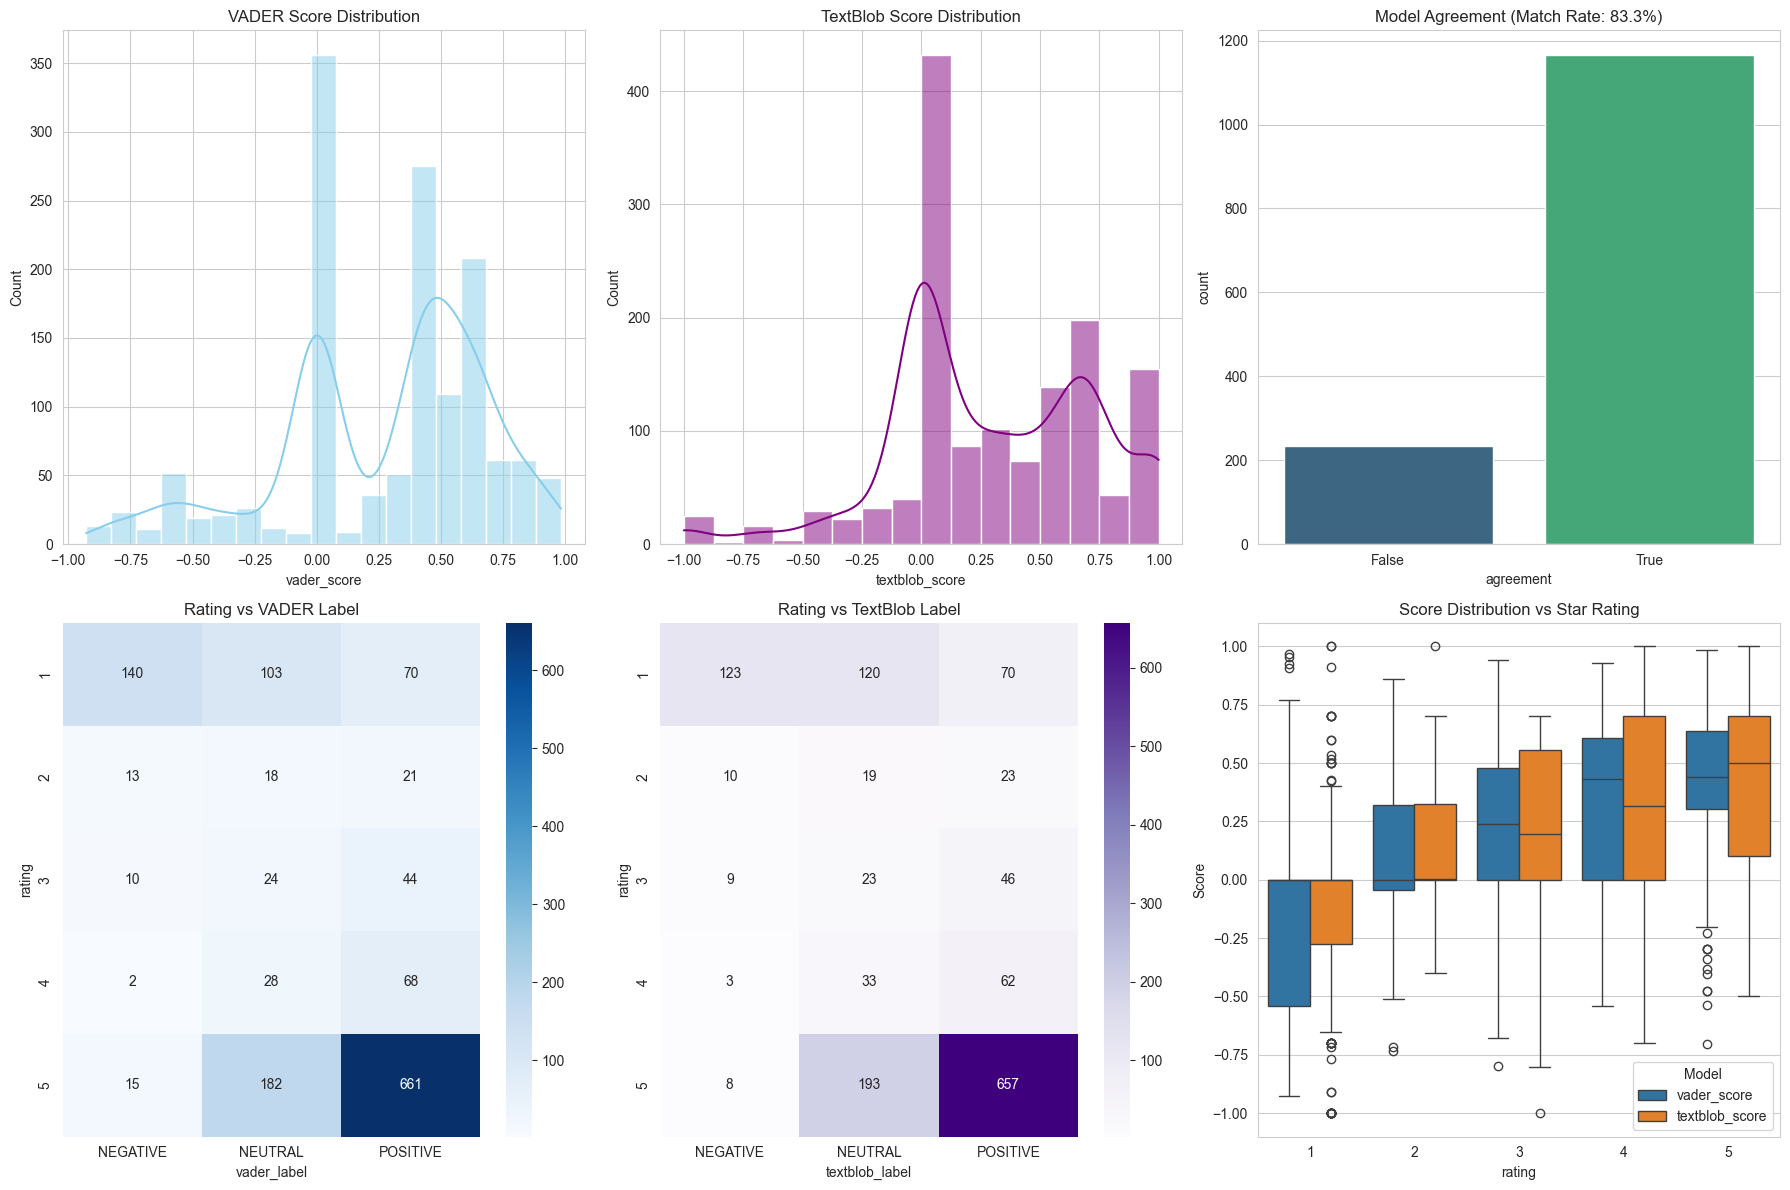

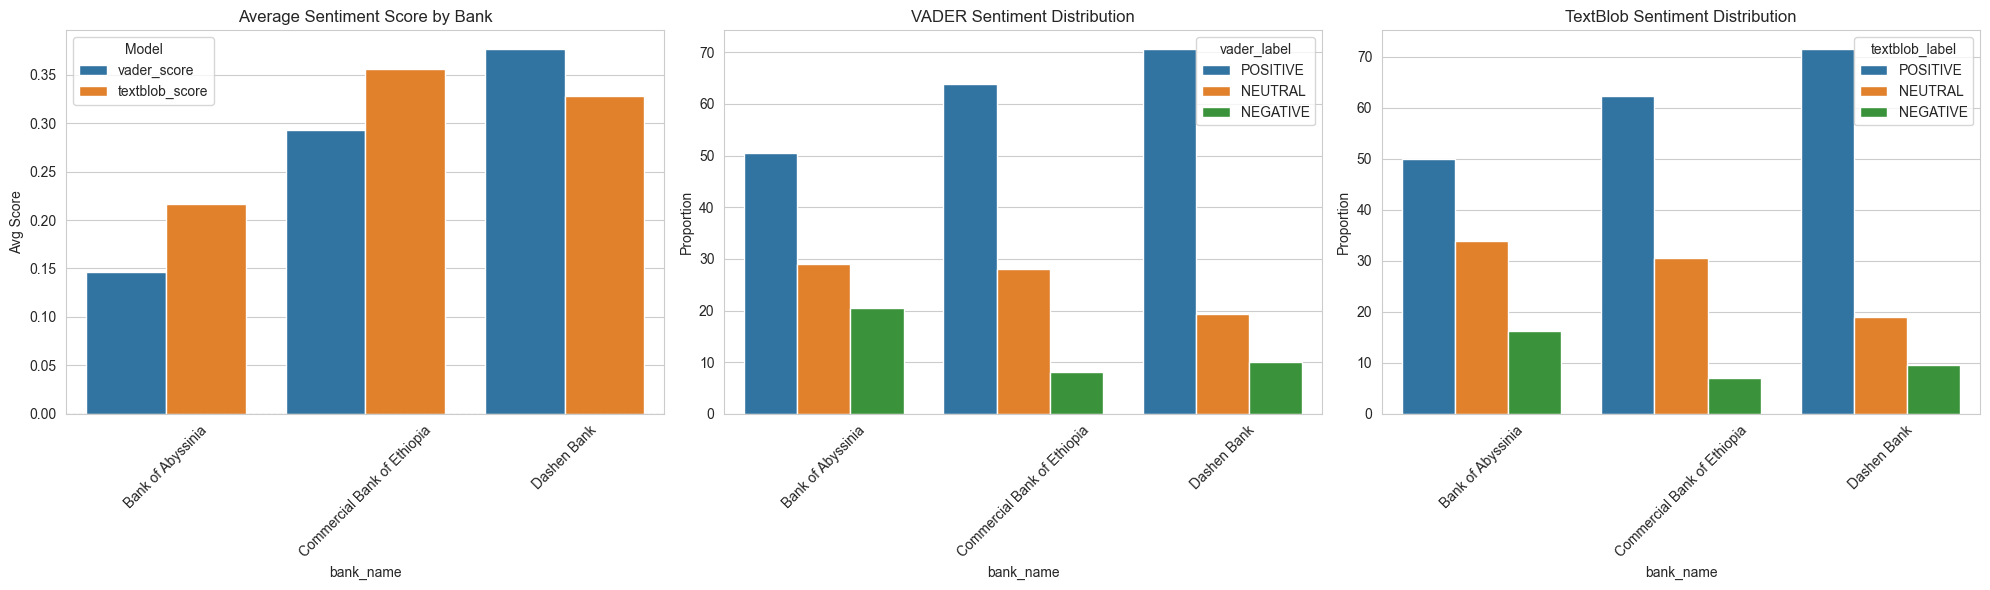

In [3]:
# -------------------------------
# 1. Model Diagnostics
# -------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Ensure columns exist
for col in ["vader_score", "textblob_score", "vader_label", "textblob_label", "rating"]:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in df")

# VADER histogram
sns.histplot(df["vader_score"], kde=True, color="skyblue", ax=axes[0,0])
axes[0,0].set_title("VADER Score Distribution")

# TextBlob histogram
sns.histplot(df["textblob_score"], kde=True, color="purple", ax=axes[0,1])
axes[0,1].set_title("TextBlob Score Distribution")

# Agreement
df["agreement"] = df["vader_label"] == df["textblob_label"]
sns.countplot(x="agreement", hue="agreement", data=df, palette="viridis", ax=axes[0,2])
axes[0,2].set_title(f"Model Agreement (Match Rate: {df['agreement'].mean():.1%})")
axes[0,2].legend_.remove()  # remove duplicate legend

# Heatmaps
sns.heatmap(pd.crosstab(df["rating"], df["vader_label"]), annot=True, fmt="d", cmap="Blues", ax=axes[1,0])
axes[1,0].set_title("Rating vs VADER Label")

sns.heatmap(pd.crosstab(df["rating"], df["textblob_label"]), annot=True, fmt="d", cmap="Purples", ax=axes[1,1])
axes[1,1].set_title("Rating vs TextBlob Label")

# Boxplot: Score vs Rating
melted = df.melt(id_vars="rating", value_vars=["vader_score", "textblob_score"], var_name="Model", value_name="Score")
sns.boxplot(x="rating", y="Score", hue="Model", data=melted, ax=axes[1,2])
axes[1,2].set_title("Score Distribution vs Star Rating")

plt.tight_layout()
plt.show()


# -------------------------------
# 2. Bank Sentiment
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # three plots: Avg, VADER, TextBlob

# 1️⃣ Average score per bank
bank_avg = df.groupby("bank_name")[["vader_score", "textblob_score"]].mean().reset_index()
bank_melt = bank_avg.melt(id_vars="bank_name", var_name="Model", value_name="Avg Score")
sns.barplot(x="bank_name", y="Avg Score", hue="Model", data=bank_melt, ax=axes[0])
axes[0].set_title("Average Sentiment Score by Bank")
axes[0].axhline(0, color="gray", linestyle="--", linewidth=0.8)
axes[0].tick_params(axis='x', rotation=45)

# 2️⃣ VADER sentiment proportions
vader_props = (
    df.groupby("bank_name")["vader_label"]
    .value_counts(normalize=True)
    .mul(100)
    .rename("Proportion")
    .reset_index()
)
sns.barplot(x="bank_name", y="Proportion", hue="vader_label", data=vader_props, ax=axes[1])
axes[1].set_title("VADER Sentiment Distribution")
axes[1].tick_params(axis='x', rotation=45)

# 3️⃣ TextBlob sentiment proportions
tb_props = (
    df.groupby("bank_name")["textblob_label"]
    .value_counts(normalize=True)
    .mul(100)
    .rename("Proportion")
    .reset_index()
)
sns.barplot(x="bank_name", y="Proportion", hue="textblob_label", data=tb_props, ax=axes[2])
axes[2].set_title("TextBlob Sentiment Distribution")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


C:\Users\amare\AppData\Local\Temp\ipykernel_16236\281508422.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=theme_counts.values, y=theme_counts.index, palette="viridis")
C:\Users\amare\AppData\Local\Temp\ipykernel_16236\281508422.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=theme_avg_rating.values, y=theme_avg_rating.index, palette="magma")


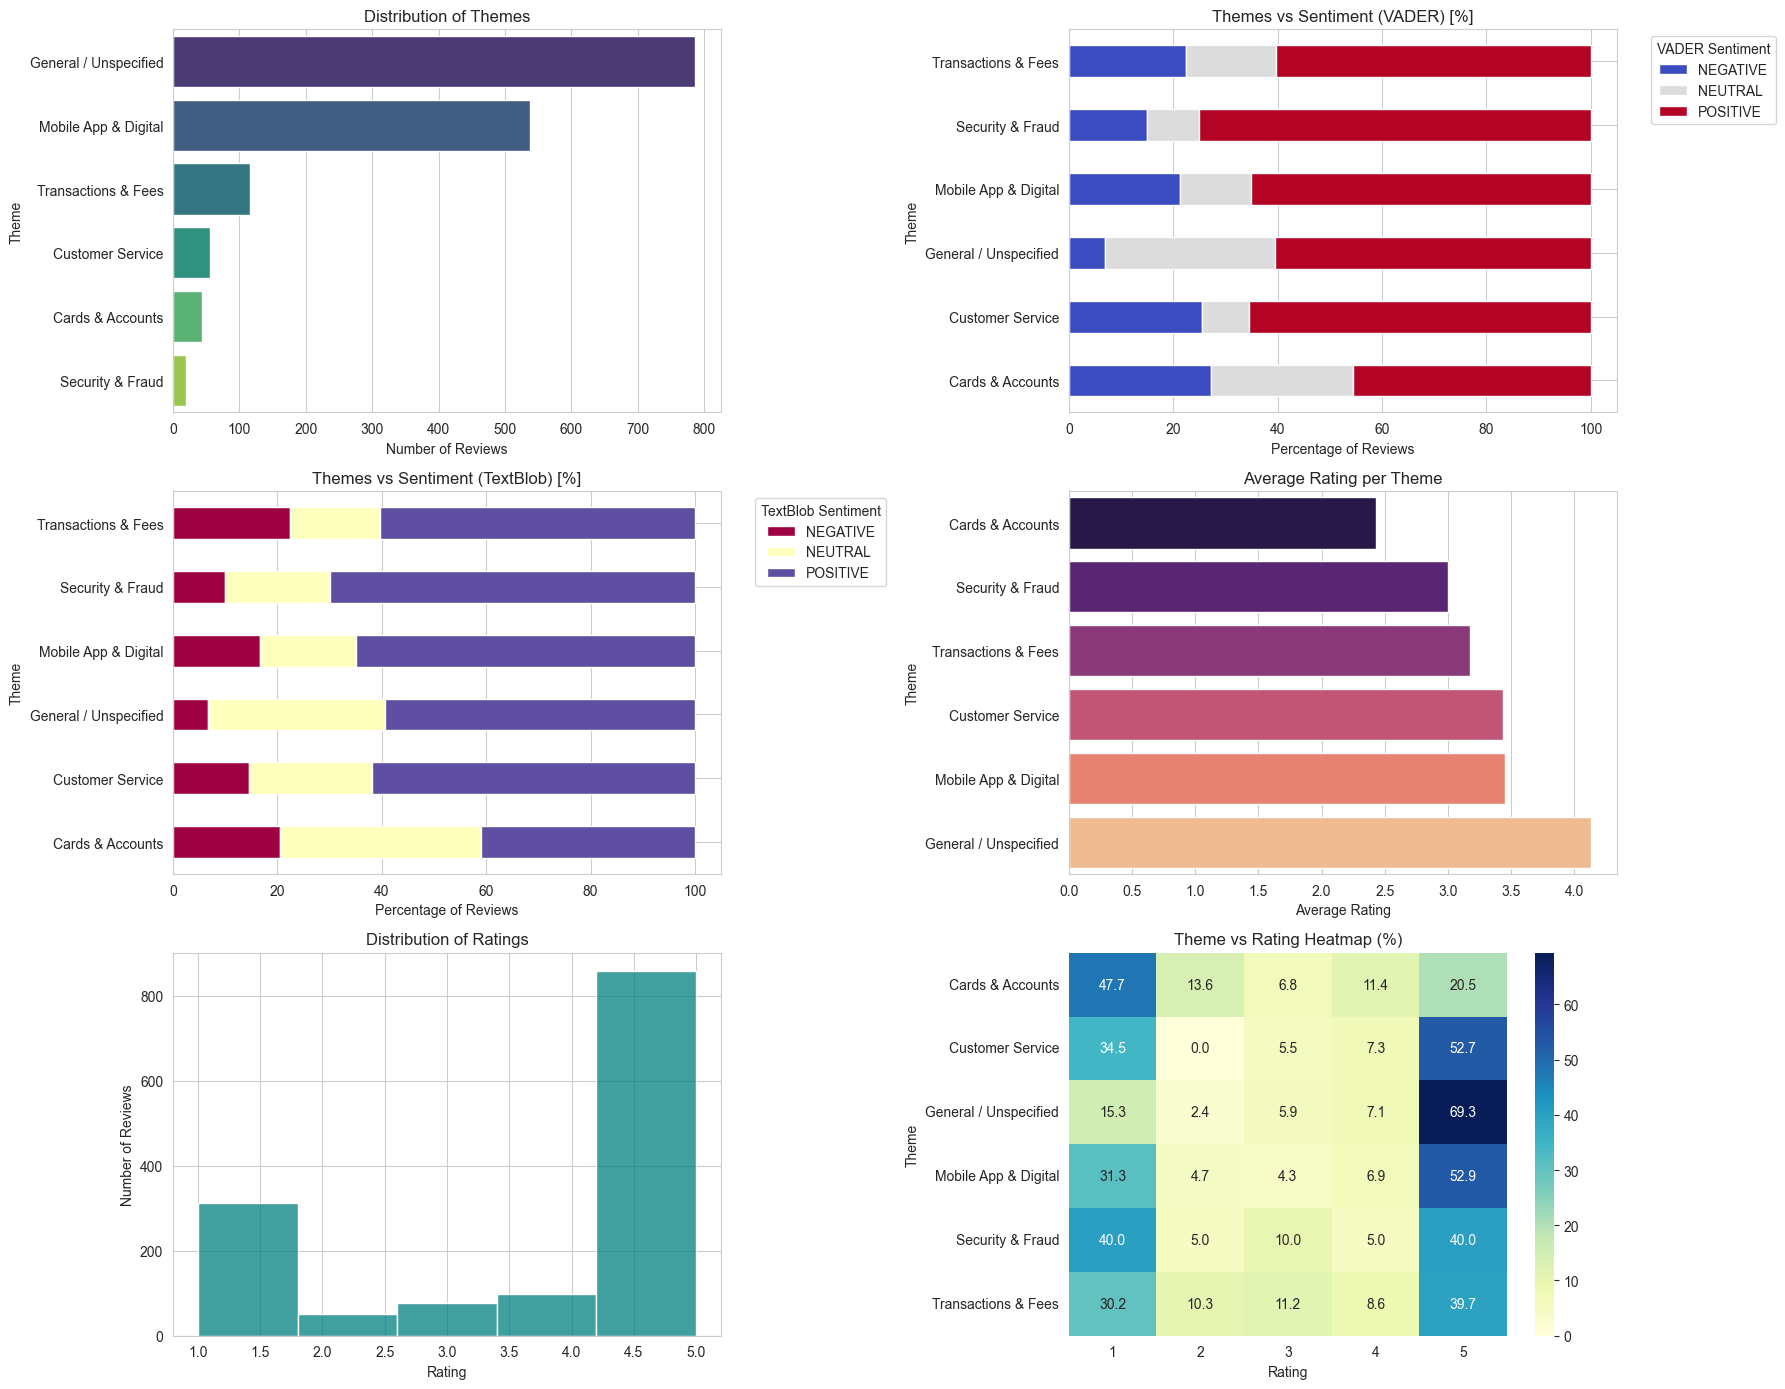

In [5]:


# Split multi-themes into separate rows for better plotting
df_expanded = df.copy()
df_expanded = df_expanded.assign(identified_theme=df_expanded['identified_theme'].str.split(', ')).explode('identified_theme')

plt.figure(figsize=(18, 14))

# ---------------------------
# 1. Theme Distribution (Count)
# ---------------------------
plt.subplot(3, 2, 1)
theme_counts = df_expanded['identified_theme'].value_counts()
sns.barplot(x=theme_counts.values, y=theme_counts.index, palette="viridis")
plt.title("Distribution of Themes")
plt.xlabel("Number of Reviews")
plt.ylabel("Theme")

# ---------------------------
# 2. Theme vs Sentiment (VADER) - Stacked
# ---------------------------
plt.subplot(3, 2, 2)
vader_props = df_expanded.groupby(['identified_theme', 'vader_label']).size().unstack(fill_value=0)
vader_props_pct = vader_props.div(vader_props.sum(axis=1), axis=0) * 100
vader_props_pct.plot(kind='barh', stacked=True, ax=plt.gca(), colormap="coolwarm")
plt.title("Themes vs Sentiment (VADER) [%]")
plt.xlabel("Percentage of Reviews")
plt.ylabel("Theme")
plt.legend(title="VADER Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

# ---------------------------
# 3. Theme vs Sentiment (TextBlob) - Stacked
# ---------------------------
plt.subplot(3, 2, 3)
tb_props = df_expanded.groupby(['identified_theme', 'textblob_label']).size().unstack(fill_value=0)
tb_props_pct = tb_props.div(tb_props.sum(axis=1), axis=0) * 100
tb_props_pct.plot(kind='barh', stacked=True, ax=plt.gca(), colormap="Spectral")
plt.title("Themes vs Sentiment (TextBlob) [%]")
plt.xlabel("Percentage of Reviews")
plt.ylabel("Theme")
plt.legend(title="TextBlob Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

# ---------------------------
# 4. Average Rating per Theme
# ---------------------------
plt.subplot(3, 2, 4)
theme_avg_rating = df_expanded.groupby("identified_theme")["rating"].mean().sort_values()
sns.barplot(x=theme_avg_rating.values, y=theme_avg_rating.index, palette="magma")
plt.title("Average Rating per Theme")
plt.xlabel("Average Rating")
plt.ylabel("Theme")

# ---------------------------
# 5. Rating Distribution
# ---------------------------
plt.subplot(3, 2, 5)
sns.histplot(df['rating'], bins=5, kde=False, color="teal")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")

# ---------------------------
# 6. Theme vs Rating Heatmap (Percent)
# ---------------------------
plt.subplot(3, 2, 6)
theme_rating_matrix = pd.crosstab(df_expanded['identified_theme'], df_expanded['rating'])
theme_rating_matrix_pct = theme_rating_matrix.div(theme_rating_matrix.sum(axis=1), axis=0) * 100
sns.heatmap(theme_rating_matrix_pct, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Theme vs Rating Heatmap (%)")
plt.xlabel("Rating")
plt.ylabel("Theme")

plt.tight_layout()
plt.show()
